# Lab 2 - The Price Is Right, Apparently
**Due**: Monday, 2/6 by 1:00pm.

Make sure you include your name and ID below for submission. <br>
**Name**:  <br>
**ID**:

## Contents

In [1]:
# load project environment
import Pkg # load the Pkg package manager
Pkg.activate(@__DIR__) # activate the environment in the directory of the script file
Pkg.instantiate() # make sure all of the needed packages are installed with correct versions

  Activating project at `~/Teaching/BEE6940/labs/lab02`


---

## Exercises

Complete the following exercises. Convert your completed notebook to a PDF and submit it to the Gradescope Assignment "Lab 2".

Remember to evaluate all of your code cells, in order (using a Run All command). This will make sure all output is visible and that the code cells were evaluated in the correct order.

### Exercise 1: The Galton Board and Normal Distributions (25 points)

#### Introduction

Suppose that we ask a class of students to walk individually from one end of a field to the other and count the number of steps that they take in order to cover the distance. More than likely, each student will get a somewhat different answer. After each student has paced off the field, we then make a histogram of the number of steps taken by the individual students.

If we were to perform this experiment with a *sufficiently* large number of students, the histogram would likely resemble a normal distribution. One way in which normal distributions arise is when a large number of measurements are taken of a single quantity, and the individual measurements are affected by random processes that are additive and that can be either positive or negative. This is one example of the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem): under uncertain conditions (finite expectation and variance), the sampling distribution of the mean converges to a normal distribution as the sample size goes to infinity.

More formally, if $\{X_1, \ldots, X_n, \ldots\} \sim X$ are independent and identically distributed samples from an arbitrary distribution $X$ with $\mathbb{E}[X_i] = \mu$ and $\text{Var}[X_i] = \sigma^2$, then if $\bar{X_n} = \frac{1}{n} \sum_{i=1}^n X_i$ is the sample average of the first $n$ samples, the distribution of $\sqrt{n}(X_n - \mu)$ converges to $\mathcal{N}(0, \sigma^2)$.

This is why political polls can report average responses and estimates of the "margin of error": the underlying assumption is that the polled individuals are independently and identically drawn from the population, and under that assumption pollsters can use the Central Limit Theorem to give an estimate of how far off their polling average is from the "true" value.

A **Galton board** (named after [Sir Francis Galton](https://en.wikipedia.org/wiki/Francis_Galton), a pioneering statistician and, notably, a eugenicist, which is unfortunately a recurring theme with leading early statisticians...), shown below, is a physical device that demonstrates the Central Limit Theorem. A Galton board has rows of pins arranged in a triangular shape, with each row of pins offset horizontally relative to the rows above and below it. The top row has one pin, the second row has two pins, and so forth. If you've watched *The Price is Right*, you've seen this as ["Plinko"](https://priceisright.fandom.com/wiki/Plinko).

![Galton Board Simulation](figures/galton_board.png)

If a ball is dropped into the Galton board, it falls either to the right or the left when it bounces off the top pin. The ball then falls all the way to the bottom of the board, moving slightly to the right or left as it passes through each row of pins. Bins at the bottom of the board capture the ball and record its final position. If this experiment is repeated with many balls, the number of balls in each bin resembles a normal distribution, which is expected due to the Central Limit Theorem.

![XKCD #2659](https://imgs.xkcd.com/comics/unreliable_connection_2x.png)

*Source: [XKCD #2659](https://xkcd.com/2659/)*

Your goal in this exercise is to explore how well a normal distribution fits the outcomes of repeated Galton Board trials as the number increases using quantile-quantile plots. Assessing the appropriateness of a probability model for a data set is a key part of exploratory analysis and uncertainty quantification; we will return to this theme repeatedly. Or, to put it another way, it's time for you to play Plinko!

#### Exercise 1.1

Write a function `galton_sim` which simulates `n_balls` Galton board trials (assume the board has 8 board rows, as in the image above) and returns a vector with the number of balls which fall into each bin. To sample the bounces, use [`StatsBase.sample`](https://juliastats.org/StatsBase.jl/stable/sampling/#StatsBase.sample). You can assume that the board is fair, e.g. that the probability of a left or right bounce is 0.5.

#### Exercise 1.2

Run your simulation for a sample of 50 balls. Create a histogram of the results, with each bar corresponding to one bin. Make sure you use a random seed for reproducibility, and label your axes!

#### Exercise 1.3

Each Galton board trial can be represented as a realization from a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). But as we noted above, by the Central Limit Theorem, the distribution of a  large enough number of trials should be approximately normal. Use a [quantile-quantile (Q-Q) plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) to compare a fitted normal distribution with your simulation results. In Julia, you can make a Q-Q plot with [`StatsPlots.qqplot()`](https://github.com/JuliaPlots/StatsPlots.jl#quantile-quantile-plots), as in the following example comparing a normal distribution to a dataset drawn from a Cauchy distribution:

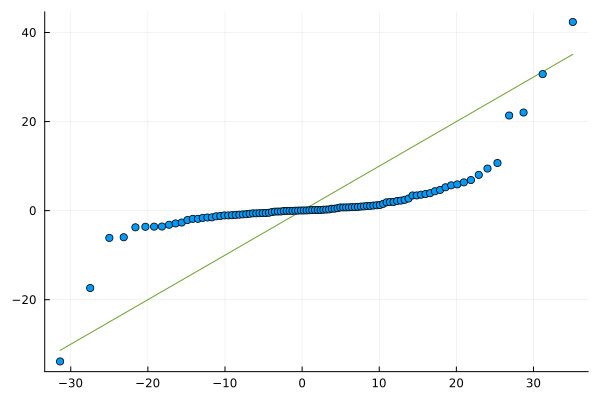

In [2]:
using Distributions
using StatsPlots
x = rand(Cauchy(), 100)
qqplot(Normal, x)

#### Exercise 1.4

Repeat your simulation experiment with 200 trials and compare to a normal distribution. Does it describe the empirical distribution better?

### Exercise 2: Monte Carlo and Expected Utility (25 points)

#### Introduction

Your mastery of the Central Limit Theorem has led you to win your game of Plinko, and it's time for the [Showcases](https://priceisright.fandom.com/wiki/Showcases). This is the final round of an episode of The Price is Right, matching the two big winners from the episode. Each contestant is shown a "showcase" of prizes, which are usually some combination of a trip, a motor vehicle, some furniture, and maybe some other stuff. They then each have to make a bid on the retail price of the showcase. The rules are:
- an overbid is an automatic loss;
- the contest who gets closest to the retail price wins their showcase;
- if a contestant gets within $\$250$ of the retail price and is closer than their opponent, they win both showcases.

In this exercise (based on an exercise in <https://leanpub.com/raes>, by Patrick Applegate, modified by [Tony Wong](https://tonyewong.github.io/index.html) and Vivek Srikrishnan), your goal is to find a wager which maximizes your expected winnings, which we may as well call utility, based on your assessment of the probability of your showcase retail price.

#### Exercise 2.1

First, write down a utility function which encodes the above rules as a function of the showcase value, your bid, and a "risk aversion" parameter (which reflects the penalty you assign to not overbidding). Program this function `showcase_utility()` in Julia.

#### Exercise 2.2

Next, suppose that from our exhaustive watching of every Price is RIght episode, we believe that showcases are approximately distributed according to a truncated normal distribution with:
- mean $\$31,000$;
- standard deviation $\$4,500$;
- lower bound $\$15,000$ and upper bound $\$42,000$.

`Distributions.jl` makes [defining truncated distributions very straightforward](https://juliastats.org/Distributions.jl/stable/truncate/).

Using this price distribution, write a function to compute a Monte Carlo estimate of the expected winnings for a given bid (assume we know that our opponent has no clue, and will ignore them for the purpose of our betting). Make a plot of this function. How did you decide how many samples to use?

#### Exercise 2.3

Finally, use [`Optim.optimize()`](https://julianlsolvers.github.io/Optim.jl/v0.9.3/user/minimization/#minimizing-a-univariate-function-on-a-bounded-interval) to find the bid which maximizes your expected winnings. You can optimize over the interval $[\$0, \$42,000]$ (since you shouldn't bid over the maximum showcase value).

## References

Give credit to any consulted references here, whether they were your classmates, online resources, or anything else.